In [183]:
import pandas as pd
from pointpats.geometry import(TREE_TYPES)
import numpy as np
from pointpats import PointPattern
from pointpats import PoissonPointProcess, PoissonClusterPointProcess, Window, poly_from_bbox, PointPattern
import libpysal as ps
from libpysal.cg import shapely_ext
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pointpats.quadrat_statistics as qs
from pointpats import PoissonPointProcess as csr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from shapely.geometry import Point, Polygon
from scipy import stats
from scipy.optimize import minimize  
from scipy import integrate  

In [81]:
tang = pd.read_pickle('/Users/gocchini/Desktop/paper_3/data/tang_non_sus.pkl')
intang = pd.read_pickle('/Users/gocchini/Desktop/paper_3/data/data_non_sus_10.pkl')


In [82]:
all_industries = pd.concat([tang, intang])

In [83]:
all_industries = all_industries[['lat', 'long']]

In [297]:
x = all_industries['lat'].to_numpy()
y = all_industries['long'].to_numpy()

In [298]:
x_min = x.min()
x_max = x.max()
y_min = y.min()
y_max = y.max()

In [299]:
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([x, y])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

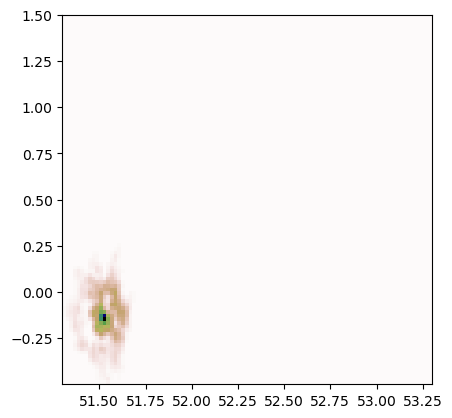

In [300]:
fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.plot(m1, m2, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()

In [244]:
# fitted function

In [241]:
values = np.vstack([x, y])
kernel = stats.gaussian_kde(values)

In [240]:
def fun_lambda(kernel, x, y):
    values = np.vstack([x, y])
    return kernel.pdf(values)

In [242]:
trial_0 = fun_lambda(kernel, x, y)

In [245]:
def fun_Neg(x):
    return -fun_lambda(x[0], x[1])

In [247]:
fun_Neg = lambda x: -fun_lambda(kernel, x[0], x[1])

In [248]:
xy0 = [(x_min + x_max) / 2, (y_min + y_max) / 2]  # initial value(ie centre)
# Find largest lambda value
resultsOpt = minimize(fun_Neg, xy0, bounds=((x_min, x_max), (y_min, y_max)))
lambda_neg_min = resultsOpt.fun  # retrieve minimum value found by minimize
lambda_max = -lambda_neg_min

In [249]:
lambda_max

95.48518780499408

In [256]:
# define thinning probability function
def fun_p(kernel, x, y):
    return fun_lambda(kernel, x, y) / lambda_max

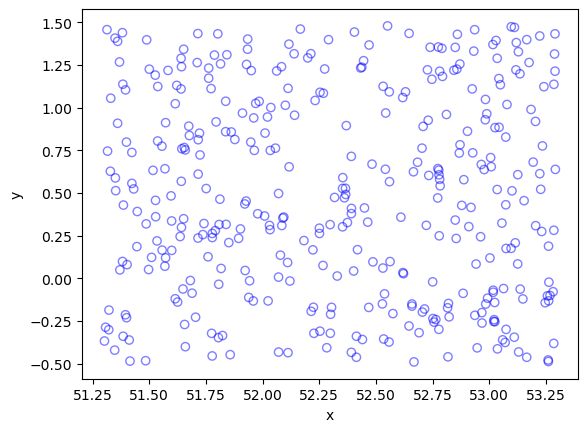

In [287]:
# Simulate a Poisson point process
n_points = np.random.poisson(area * lambda_max)  # Poisson number of points
xx = np.random.uniform(0, x_delta, n_points) + x_min  # x coordinates of Poisson points
yy = np.random.uniform(0, y_delta, n_points) + y_min  # y coordinates of Poisson points

# calculate spatially-dependent thinning probabilities
p = fun_p(kernel, xx, yy)

# Generate Bernoulli variables (ie coin flips) for thinning
booleThinned = np.random.uniform(0, 1, n_points) < p  # points to be thinned
booleRetained = ~booleThinned  # points to be retained

# x/y locations of thinned points
xxThinned = xx[booleThinned]
yyThinned = yy[booleThinned]
# x/y locations of retained points
xxRetained = xx[booleRetained]
yyRetained = yy[booleRetained]

# Plotting
plt.scatter(xxRetained, yyRetained, edgecolor='b', facecolor='none', alpha=0.5)
plt.scatter(xxThinned, yyThinned, edgecolor='r', facecolor='none', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

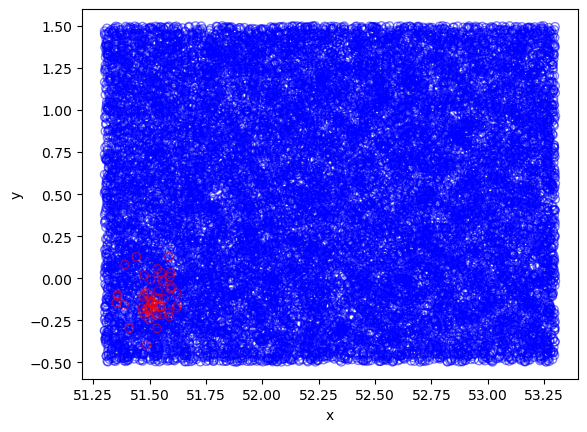

In [291]:
# Simulate a Poisson point process
n_points = 20000 # Poisson number of points
xx = np.random.uniform(0, x_delta, n_points) + x_min  # x coordinates of Poisson points
yy = np.random.uniform(0, y_delta, n_points) + y_min  # y coordinates of Poisson points

# calculate spatially-dependent thinning probabilities
p = fun_p(kernel, xx, yy)

# Generate Bernoulli variables (ie coin flips) for thinning
booleThinned = np.random.uniform(0, 1, n_points) < p  # points to be thinned
booleRetained = ~booleThinned  # points to be retained

# x/y locations of thinned points
xxThinned = xx[booleThinned]
yyThinned = yy[booleThinned]
# x/y locations of retained points
xxRetained = xx[booleRetained]
yyRetained = yy[booleRetained]

# Plotting
plt.scatter(xxRetained, yyRetained, edgecolor='b', facecolor='none', alpha=0.5)
plt.scatter(xxThinned, yyThinned, edgecolor='r', facecolor='none', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [301]:
xmin = xxThinned.min()
xmax = xxThinned.max()
ymin = yyThinned.min()
ymax = yyThinned.max()

In [302]:
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([xxThinned, yyThinned])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

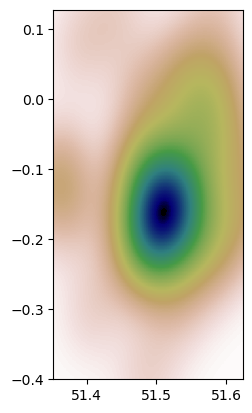

In [303]:
fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.plot(m1, m2, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()

# Simulate pattern 1000 times

In [334]:
n_sim = 10**3
# Simulate a 1000 Poisson point process
xx_list = []
yy_list = []
for i in range(n_sim):
    n_points = 20000 # Poisson number of points
    xx = np.random.uniform(0, x_delta, n_points) + x_min  # x coordinates of Poisson points
    yy = np.random.uniform(0, y_delta, n_points) + y_min  # y coordinates of Poisson points

    # calculate spatially-dependent thinning probabilities
    p = fun_p(kernel, xx, yy)

    # Generate Bernoulli variables (ie coin flips) for thinning
    booleThinned = np.random.uniform(0, 1, n_points) < p  # points to be thinned
    booleRetained = ~booleThinned  # points to be retained

    # x/y locations of thinned points
    xxThinned = xx[booleThinned]
    yyThinned = yy[booleThinned]
    # x/y locations of retained points
    xxRetained = xx[booleRetained]
    yyRetained = yy[booleRetained]

    #make dataframe
    xx_list.append(xxThinned)
    yy_list.append(yyThinned)

simulated_companies = pd.DataFrame(zip(xx_list, yy_list))


SyntaxError: positional argument follows keyword argument (2479146026.py, line 28)

In [333]:
simulated_companies

,0,1
0,"[51.54218582497672, 51.589472314705674, 51.381...","[-0.0874064825256965, -0.24605053217241302, -0..."
1,"[51.55988941008741, 51.46151770699342, 51.4621...","[-0.2039481156403623, -0.10841744337054215, -0..."
2,"[51.56214130611294, 51.51280788687047, 51.3606...","[-0.12966170920812858, -0.2826523378177931, -0..."
3,"[51.56170641195442, 51.52023769828351, 51.4886...","[-0.166205136211394, -0.13644063967513753, -0...."
4,"[51.4906797623787, 51.497014131477584, 51.5169...","[-0.1896979435260494, -0.17099360746609682, -0..."
...,...,...
995,"[51.63935421745579, 51.706750976828324, 51.542...","[-0.07261284013816416, -0.009181363548142474, ..."
996,"[51.61569290725654, 51.63541106925196, 51.5147...","[0.11716453816526606, 0.122925519204793, -0.16..."
997,"[51.52412280586476, 51.491516413109416, 51.459...","[-0.14427792343017554, -0.3858098677670566, 0...."
998,"[51.57654497729315, 51.54095405036929, 51.5460...","[0.05455564471325014, -0.27824276403446013, -0..."


In [286]:
# stupid stuff below :) 

In [ ]:
def fun_lambda(x, y):
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    kde_function = kernel.pdf(values)
    return kde_function 

In [235]:
from sklearn.neighbors import KernelDensity

def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx,yy,zz